### [Augmentations for Object Detection - Scale & Translate](https://blog.paperspace.com/data-augmentation-bounding-boxes-scaling-translation/)

In [1]:
import os
import cv2
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def draw_box(img, coords):
    """
    Function to draw bounding boxes on image.
    """
    img = img.copy()
    coords = coords.reshape(-1, 5)
    for coord in coords:
        ul_pt = (int(coord[0]), int(coord[1]))  # Upper left point
        br_pt = (int(coord[2]), int(coord[3]))  # Bottom right point
        if int(coord[4]) == 0:
            color = [255, 255, 255]
        else:
            color = [255, 255, 0]
        
        img = cv2.rectangle(img.copy(), ul_pt, br_pt, color, 
                            int(max(img.shape[:2])/200))
    return img

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

def clip_bbox(bbox, clip_box, drop=0.2):
    """
    Clip bounding boxes to the borders of an image
    
    clip_box: Coordinates of image in x1, y1, x2, y2 format
    drop: If fraction of bounding box left after clipping is less 
           than drop the bounding is dropped
    """
    bb_area = bbox_area(bbox)
    
    # Updated bounding box coordinates
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1, 1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1, 1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1, 1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1, 1)
    
    # Update bounding box coordinates
    c_bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:, 4:]))
    
    # Area of clipped bounding box
    cbb_area = bbox_area(c_bbox)
    
    # Fraction of bounding box that was clipped
    delta_area = (bb_area - cbb_area)/bb_area
    
    # Mask: Drop boxes that have less than `drop` fraction 
    mask = (delta_area < (1 - drop)).astype(int)
    
    # Drop bboxes that 
    return c_bbox[mask == 1, :]

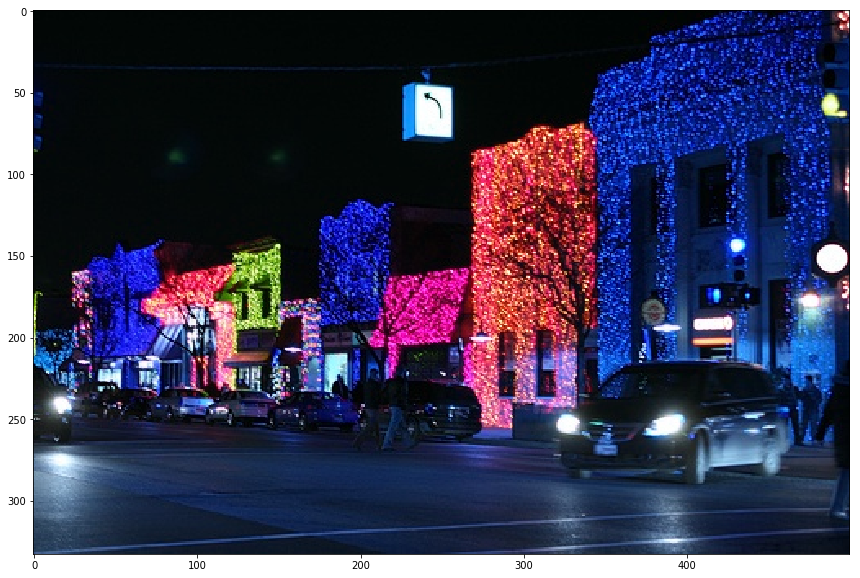

In [3]:
# Sample image from Pascal VOC with bounding box
img = cv2.imread('002244.jpg')

bboxes = np.array([[317, 215, 465, 292, 0],
                   [144, 233, 201, 266, 0],
                   [200, 227, 274, 263, 0],
                   [197, 217, 217, 272, 1],
                   [479, 214, 500, 319, 1]])
plt.figure(figsize=(20,10))
plt.imshow(img)

**Scale: Design Considerations**
- Scaling factor should not be less than **-1**
- Maintain aspect ratio by constraining the scaling factor to be the same for both width and height
- Allow scale factors to differ - This changes the aspect ratio of the images

In [4]:
class RandomScale:
    """
    Randomly scales and image.
    
    scale : float or tuple of floats
    fixed : bool, fix aspect ratio or not
    """
    def __init__(self, scale=0.2, fixed=True):
        self.scale = scale
        self.fixed = fixed
        if isinstance(self.scale, tuple):
            assert len(self.scale) == 2, "Range is not valid"
            assert self.scale[0] > -1, "Scale factor can not be less than -1"
            assert self.scale[1] > -1, "Scale factor can not be less than -1"
        else:
            assert self.scale > 0, "Input is a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
            
    def __call__(self, img, bboxes):
        
        img_shape = img.shape
        
        # Different scales
        if not self.fixed:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x

        # Scales for resizing
        resize_scale_x = scale_x + 1
        resize_scale_y = scale_y + 1

        # Scale image
        s_img = cv2.resize(img, dsize=None, fx=resize_scale_x, fy=resize_scale_y)

        # Scale bounding boxes
        s_bboxes = bboxes.copy()
        s_bboxes[:, :4] = s_bboxes[:, :4] * [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]

        # Keeping image size constant
        canvas = np.zeros(img_shape, dtype=np.uint8)

        # Find limits to extract data from scaled image
        x_lim = int(min(resize_scale_x, 1) * img_shape[0])
        y_lim = int(min(resize_scale_y, 1) * img_shape[1])

        # Extract data from scaled image and paste on the canvas
        canvas[:x_lim, :y_lim, :] = s_img[:x_lim, :y_lim, :]

        # Clip bounding box
        cs_bboxes = clip_bbox(s_bboxes, [0, 0, img_shape[1], img_shape[0]], 0.25)

        return canvas, cs_bboxes

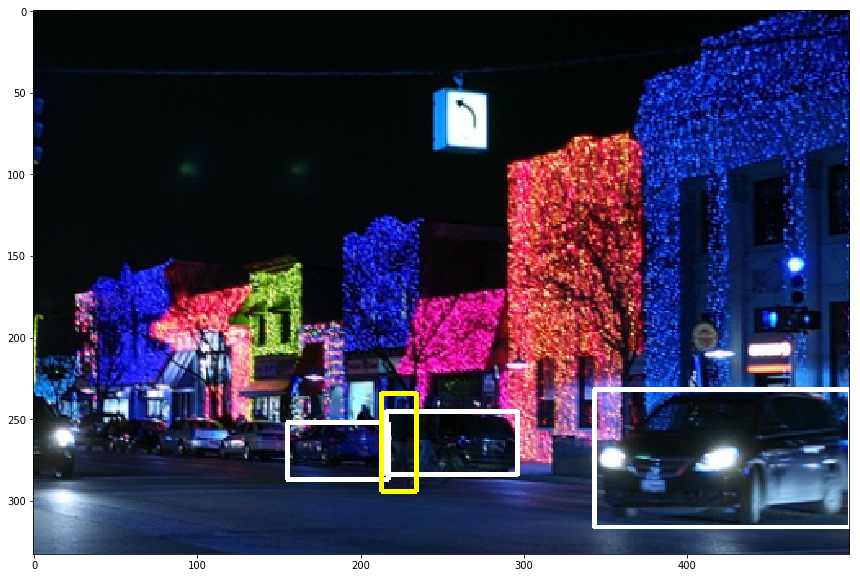

In [5]:
# Test random scale
scaler = RandomScale(fixed=True)
s_img, s_bboxes = scaler(img, bboxes)
plt.figure(figsize=(20,10))
plt.imshow(draw_box(s_img, s_bboxes))

**Translate: Design Considerations**

- Translate factor should not be less than **-1** as well as it should not be greater than **1**


In [6]:
class RandomTranslate:

    def __init__(self, translate=0.2, fixed=True):
        self.translate = translate
        self.fixed = fixed

        if isinstance(self.translate, tuple):
            assert len(self.translate) == 2, "Invalid range"
            assert self.translate[0] > 0 and self.translate[0] < 1, "Value should be between 0 and 1"
            assert self.translate[1] > 0 and self.translate[1] < 1, "Value should be between 0 and 1"
        else:
            assert self.translate > 0 and self.translate < 1
            self.translate = (-self.translate, self.translate)

    def __call__(self, img, bboxes):

        img_shape = img.shape

        # Percent of the dimension of the imageto translate
        translate_x = random.uniform(*self.translate)
        translate_y = random.uniform(*self.translate)

        if self.fixed:
            translate_y = translate_x

        # Initialize black image of size equal to original image size
        canvas = np.zeros(img_shape, dtype=np.uint8)

        # Get UL corner coordinates of the translated image
        corner_x = int(translate_x * img_shape[0])
        corner_y = int(translate_y * img_shape[1])

        # Change origin to UL corner of translated box
        xt_a = max(-corner_x, 0)
        xt_b = min(img_shape[0], -corner_x + img_shape[0])
        yt_a = max(-corner_y, 0)
        yt_b = min(img_shape[1], -corner_y + img_shape[1])

        # Extract patch of image which will be pasted on canvas
        patch = img[xt_a:xt_b, yt_a:yt_b, :]

        # Find coordinates on canvas to paste patch
        xc_a = max(0, corner_x)
        xc_b = min(img_shape[0], corner_x + img_shape[0])
        yc_a = max(0, corner_y)
        yc_b = min(img_shape[1], corner_y + img_shape[1])

        # Paste extracted patch on canvas
        canvas[xc_a:xc_b, yc_a:yc_b, :] = patch

        # Translate bounding box: Offset the corners of the bounding box
        t_bboxes = bboxes.copy()
        t_bboxes[:, :4] = t_bboxes[:, :4] + [corner_x, corner_y, corner_x, corner_y]

        # Clip bounding box
        ct_bboxes = clip_bbox(t_bboxes, [0, 0, img_shape[1], img_shape[0]], 0.25)

        return canvas, ct_bboxes

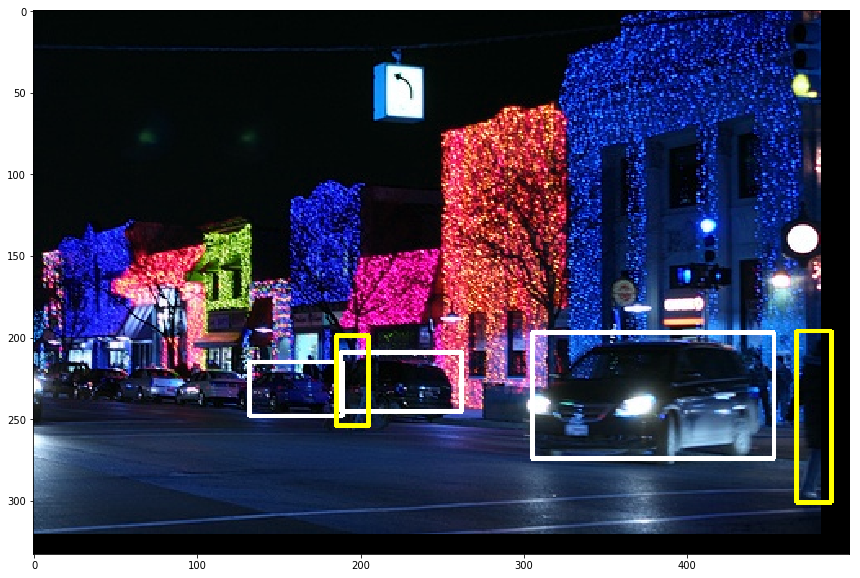

In [7]:
# Test random translate
translate = RandomTranslate(fixed=True)
t_img, t_bboxes = translate(img, bboxes)
plt.figure(figsize=(20,10))
plt.imshow(draw_box(t_img, t_bboxes))

## Scratch

In [8]:
img = cv2.imread('002244.jpg')
bboxes = np.array([[317, 215, 465, 292, 0],
                   [144, 233, 201, 266, 0],
                   [200, 227, 274, 263, 0],
                   [197, 217, 217, 272, 1],
                   [479, 214, 500, 319, 1]])

img_shape = img.shape
print(img_shape)

(333, 500, 3)


In [9]:
scale = 0.2
scale = (max(-1, -scale), scale)
print(scale)

(-0.2, 0.2)


In [10]:
# Different scales
scale_x = random.uniform(*scale)
scale_y = random.uniform(*scale)
print(scale_x, scale_y)

-0.04310147107933021 -0.18720392570063538


In [11]:
# Fixed aspect ratio
scale_x = random.uniform(*scale)
scale_y = scale_x
print(scale_x, scale_y)

-0.1867638334880189 -0.1867638334880189


In [12]:
# Scales for resizing
resize_scale_x = scale_x + 1
resize_scale_y = scale_y + 1
print(resize_scale_x, resize_scale_y)

0.8132361665119812 0.8132361665119812


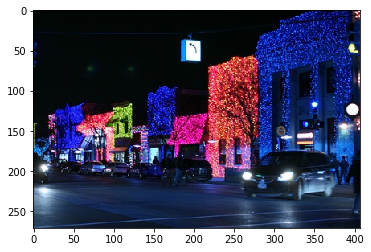

In [13]:
# Scale image
s_img = cv2.resize(img, dsize=None, fx=resize_scale_x, 
                   fy=resize_scale_y)

plt.imshow(s_img)

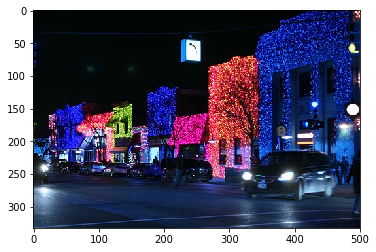

In [14]:
# Original image
plt.imshow(img)

In [15]:
# Scale bounding boxes
s_bboxes = bboxes.copy()
s_bboxes[:, :4] = s_bboxes[:, :4] * [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
s_bboxes

array([[257, 174, 378, 237,   0],
       [117, 189, 163, 216,   0],
       [162, 184, 222, 213,   0],
       [160, 176, 176, 221,   1],
       [389, 174, 406, 259,   1]])

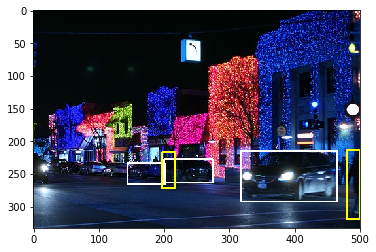

In [16]:
# Original
plt.imshow(draw_box(img, bboxes))

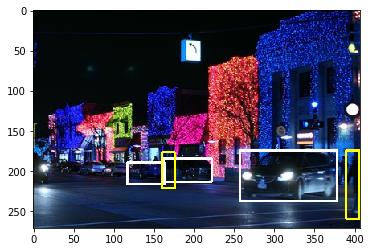

In [17]:
# Scaled
plt.imshow(draw_box(s_img, s_bboxes))

In [18]:
# Size comparison
print(img.shape, s_img.shape)

(333, 500, 3) (271, 407, 3)


In [19]:
# Keeping image size constant
canvas = np.zeros(img.shape, dtype=np.uint8)

In [20]:
# Find limits to extract data from scaled image
x_lim = int(min(resize_scale_x, 1) * img_shape[0])
y_lim = int(min(resize_scale_y, 1) * img_shape[1])
print(x_lim, y_lim)

270 406


In [21]:
# Extract data from scaled image and paste on the canvas
canvas[:x_lim, :y_lim, :] = s_img[:x_lim, :y_lim, :]
s_img = canvas

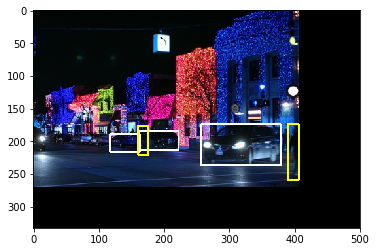

In [22]:
# Scaled with size constant
plt.imshow(draw_box(s_img, s_bboxes))

In [23]:
# Bounding box clipping

alpha = 0.15

# Calculate area of scaled bounding boxes
s_area = bbox_area(s_bboxes)
print(s_area)

[7623 1242 1740  720 1445]


In [24]:
# Clip box
clip_box = [0, 0, img_shape[0], img_shape[1]]
print(clip_box)

[0, 0, 333, 500]


In [25]:
# Updated bounding box coordinates
x_min = np.maximum(s_bboxes[:,0], clip_box[0]).reshape(-1, 1)
y_min = np.maximum(s_bboxes[:,1], clip_box[1]).reshape(-1, 1)
x_max = np.minimum(s_bboxes[:,2], clip_box[2]).reshape(-1, 1)
y_max = np.minimum(s_bboxes[:,3], clip_box[3]).reshape(-1, 1)

In [26]:
# Update bounding box coordinates
cs_bboxes = np.hstack((x_min, y_min, x_max, y_max, s_bboxes[:, 4:]))
cs_bboxes

array([[257, 174, 333, 237,   0],
       [117, 189, 163, 216,   0],
       [162, 184, 222, 213,   0],
       [160, 176, 176, 221,   1],
       [389, 174, 333, 259,   1]])

In [27]:
# Area of clipped scaled bounding boxes
cs_area = bbox_area(cs_bboxes)
cs_area

array([ 4788,  1242,  1740,   720, -4760])

In [28]:
# Fraction of bounding box that was clipped
delta_area = (s_area - cs_area)/s_area
delta_area

array([0.37190083, 0.        , 0.        , 0.        , 4.29411765])

In [29]:
# Mask
mask = (delta_area < (1 - alpha)).astype(int)
mask

array([1, 1, 1, 1, 0])

In [30]:
# Remove boxes 
rcs_bboxes = cs_bboxes[mask == 1, :]
rcs_bboxes

array([[257, 174, 333, 237,   0],
       [117, 189, 163, 216,   0],
       [162, 184, 222, 213,   0],
       [160, 176, 176, 221,   1]])

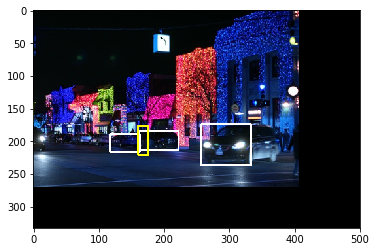

In [31]:
# Scaled with size constant and removed and clipped boxes
plt.imshow(draw_box(s_img, rcs_bboxes))

(333, 500, 3)


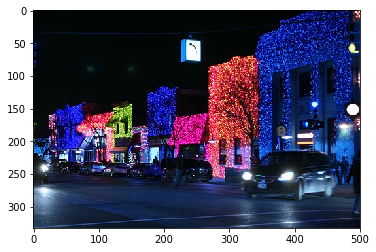

In [32]:
# Translate

img = cv2.imread('002244.jpg')
bboxes = np.array([[317, 215, 465, 292, 0],
                   [144, 233, 201, 266, 0],
                   [200, 227, 274, 263, 0],
                   [197, 217, 217, 272, 1],
                   [479, 214, 500, 319, 1]])

img_shape = img.shape
print(img_shape)
plt.imshow(img)

In [33]:
translate = 0.2
assert translate > 0 and translate < 1
translate = (-translate, translate)
print(translate)

(-0.2, 0.2)


In [34]:
# Different translate factor for directions
translate_x = random.uniform(*translate)
translate_y = random.uniform(*translate)
print(translate_x, translate_y)

-0.13282495574686626 0.09988810287412547


In [35]:
# Fixed aspect ratio: Same translate factor for directions
translate_x = random.uniform(*translate)
translate_y = translate_x
print(translate_x, translate_y)

0.06024500597228555 0.06024500597228555


In [36]:
# Initialize black image of size equal to original image size
canvas = np.zeros(img_shape, dtype=np.uint8)

In [37]:
# Get UL corner coordinates of the translated image
corner_x = int(translate_x * img_shape[0])
corner_y = int(translate_y * img_shape[1])
print(corner_x, corner_y)

20 30


In [38]:
# Change origin to UL corner of translated box

print(img_shape)

# x coordinate 
print(max(-corner_x, 0))
print(min(img_shape[0], -corner_x + img_shape[0]))

xt_a = max(-corner_x, 0)
xt_b = min(img_shape[0], -corner_x + img_shape[0])
print(xt_a, xt_b)

# y coordinate
print(max(-corner_y, 0))
print(min(img_shape[1], -corner_y + img_shape[1]))

yt_a = max(-corner_y, 0)
yt_b = min(img_shape[1], -corner_y + img_shape[1])
print(yt_a, yt_b)

(333, 500, 3)
0
313
0 313
0
470
0 470


(313, 470, 3)


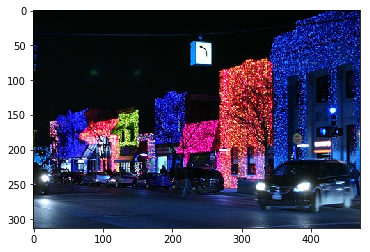

In [39]:
# Extract patch of image which will be pasted on canvas
mask = img[xt_a:xt_b, yt_a:yt_b, :]
print(mask.shape)

plt.imshow(mask)

In [40]:
# Find coordinates on canvas to paste mask
print(canvas.shape)

# x
print(max(0, corner_x))
print(min(img_shape[0], corner_x + img_shape[0]))
oxa = max(0, corner_x)
oxb = min(img_shape[0], corner_x + img_shape[0])
print(oxa, oxb)

# y
print(max(0, corner_y))
print(min(img_shape[1], corner_y + img_shape[1]))
oya = max(0, corner_y)
oyb = min(img_shape[1], corner_y + img_shape[1])
print(oya, oyb)

(333, 500, 3)
20
333
20 333
30
500
30 500


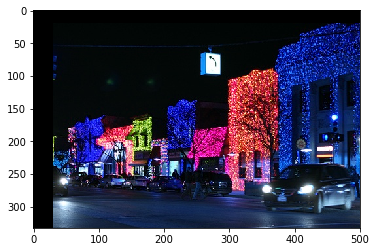

In [41]:
# Paste extracted patch on canvas
canvas[oxa:oxb, oya:oyb, :] = mask
t_img = canvas
plt.imshow(t_img)

In [42]:
# Translate bounding box: Offset the corners of the bounding box
t_bboxes = bboxes.copy()
t_bboxes[:, :4] = t_bboxes[:, :4] + [corner_x, corner_y, corner_x, corner_y]
t_bboxes

array([[337, 245, 485, 322,   0],
       [164, 263, 221, 296,   0],
       [220, 257, 294, 293,   0],
       [217, 247, 237, 302,   1],
       [499, 244, 520, 349,   1]])

In [43]:
# Clip translated bounding boxes
clip_box = [0, 0, img_shape[0], img_shape[1]]

ct_bboxes = clip_bbox(t_bboxes, clip_box, 0.05)
ct_bboxes

array([[164, 263, 221, 296,   0],
       [220, 257, 294, 293,   0],
       [217, 247, 237, 302,   1]])

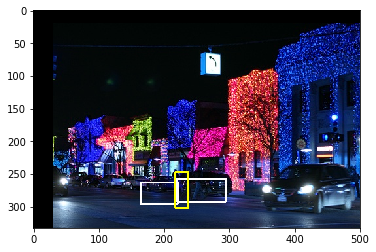

In [44]:
plt.imshow(draw_box(t_img, ct_bboxes))

### Other Techniques

- Shifting images vertically or horizontally
- Histogram equalization techniques 
    - Histogram equalization
    - Contrast stretching
    - Adaptive equalization